<a href="https://colab.research.google.com/github/MMathisLab/LINdoscope2023/blob/main/notebooks/CEBRA_LINdoscope2023_1Pdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👋  Welcome to the CEBRA demo!

![alt text](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/6f3943a1-b76d-4674-9df9-87aebd33e517/cebralogo.png?format=2500w)


 - Hello, LINdoscope 2023!

 - This demo is aimed at showing you how to use CEBRA on the 1P dataset from the LINdoscope alumns (thanks!)
 - But for many more options, ideas, and demos we really recommend checking out: [cebra.ai/demos](https://cebra.ai/docs/demos.html)

##### Authored by Anastasiia Filippova & Mackenzie Mathis (MW Mathis Lab @ EPFL)

In [1]:
!pip install cebra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import cebra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cebra.integrations.matplotlib as cebra_plot

from cebra import CEBRA

## Data loading, preprocessing, checks

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Lets be sure you have access to the drive! You may need to mount this to add a link in your "My Drive" directory.
# you should see the DLC_models directory:
%cd /content/drive/MyDrive/LINdoscope2023_analysis
%ls

/content/drive/.shortcut-targets-by-id/1MCbA_XWnvaUo_aH2Nu4A3Sg_UwDbwAia/LINdoscope2023_analysis
cebra_cebra_beh_model.pt  docs/       sample_data/
DLC_models/               README.txt  student_data/


In [10]:
data_path = '/content/drive/MyDrive/LINdoscope2023_analysis/sample_data/CEBRA/'
dlc_path = '1P_dCA1_openfield_15hzDLC_resnet50_Retrained_VGluT2_OpenFieldMar29shuffle1_800000.h5'
calcium_trace_path = '1P_dCA1_openfield_15hz_tracesC.csv'

### Data loading

We have awesome integration of DeepLabCut, look [here](https://cebra.ai/docs/api/pytorch/data.html#cebra.load_deeplabcut) for more usage information on how to use deeplabcut output file directly with `cebra.load_deeplabcut`. Let's use it!

In [11]:
keypoints = cebra.load_deeplabcut(f'{data_path}/{dlc_path}')

In [12]:
neural_data = pd.read_csv(f'{data_path}/{calcium_trace_path}',
                          low_memory=False, skiprows=[1])

### Let's quickly look at the data:

In [13]:
neural_data.head()

,,C000,C001,C002,C003,C004,C005,C006,C007,C008,...,C862,C863,C864,C865,C866,C867,C868,C869,C870,C871
0,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.066667,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,...,7.422050,0.000000,0.0,0.546204,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.133333,0.0,0.000000e+00,0.072662,0.000000e+00,0.0,0.000000e+00,0.0,0.476917,0.0,...,6.700374,0.511189,0.0,0.470934,2.244547,0.0,0.0,0.0,0.000000,0.196596
3,0.200000,0.0,0.000000e+00,0.055022,-2.980232e-08,0.0,-1.192093e-07,0.0,0.419907,0.0,...,6.048870,0.448426,0.0,0.406037,1.923557,0.0,0.0,0.0,4.972352,0.172676
4,0.266667,0.0,-1.490116e-08,0.041665,-2.980232e-08,0.0,-1.192093e-07,0.0,1.326608,0.0,...,5.460714,0.393370,0.0,0.350083,1.648471,0.0,0.0,0.0,3.907864,0.216435


### Spliting the data

The dataframe is a concatenation of 3 sessions with time gap of 3-5 minutes, we **do not** recommend to use the concatenation for training. So let's split into different sessions!

In [14]:
#lengths of sessions
lens = [3270, 3140, 3510]

In [17]:
def align_poses(keypoints):
    """
    Aligns 2D keypoints by translating them to the mean position and scaling them based on the bounding box size.

    Args:
        keypoints (numpy.ndarray): 2D array of keypoints with shape (n_frames, n_kpts, 2).

    Returns:
        numpy.ndarray: Aligned keypoints with the same shape as the input.
    """
    n_frames, n_kpts = keypoints.shape
    aligned_keypoints = np.copy(keypoints)
    # Compute mean position across all frames
    mean_position = np.mean(aligned_keypoints, axis=(0, 1))
    # Translate keypoints to mean position
    aligned_keypoints -= mean_position
    # Compute maximum absolute coordinate value across all frames
    max_abs_coord = np.max(np.abs(aligned_keypoints))
    # Scale keypoints based on bounding box size
    aligned_keypoints /= max_abs_coord

    return aligned_keypoints

In [18]:
def split_into_sessions(neural, behaviour, lens):

    sessions = []

    abs_lens = np.hstack([np.zeros(1, dtype='int'),
                          np.cumsum(lens)])
    aligned_behaviour = align_poses(behaviour)
    slices = [slice(abs_lens[i], abs_lens[i+1])
              for i in range(len(lens))]
    for session_slice in slices:
        sessions.append({
            'neural': neural[session_slice],
            'behaviour': behaviour[session_slice],
            'nose_position': np.linalg.norm(behaviour[session_slice][:, :2], axis=1),
            'tail_position': np.linalg.norm(behaviour[session_slice][:, 2:4], axis=1)
        })
    return sessions

In [19]:
sessions = split_into_sessions(neural_data, keypoints, lens)

We have estimated keypoints with [DeepLabCut](https://github.com/DeepLabCut/DeepLabCut), let's use them:)

We might want to extract position. Let's calculate the tail position and use it aa a behaviour label.

In [20]:
def get_position(array):

    position = np.linalg.norm(array, axis=1)

    return position

In [21]:

#get tail position from estimated keypoints
tail_position = get_position(keypoints[:, 2:4])

# 🦓 CEBRA training

- we recommend to start with CEBRA single session on each trial

- you can find our suggested workflow here: https://cebra.ai/docs/usage.html

## Single-session training w/CEBRA-Behavior

In [22]:
embeddings = dict()

for i, session in enumerate(sessions):

    cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=5000,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)
    cebra_model.fit(session['neural'], session['tail_position'])
    embeddings[i] = cebra_model.transform(session['neural'])

pos:  0.2204 neg:  5.4325 total:  5.6529 temperature:  1.0000: 100%|██████████| 5000/5000 [01:18<00:00, 63.48it/s]
pos:  0.2719 neg:  5.4385 total:  5.7104 temperature:  1.0000: 100%|██████████| 5000/5000 [01:10<00:00, 71.39it/s]
pos:  0.3035 neg:  5.4671 total:  5.7706 temperature:  1.0000: 100%|██████████| 5000/5000 [01:02<00:00, 79.47it/s]


## Analyze the embedding, part 1:
- plot embedding #1

<IPython.core.display.Javascript object>

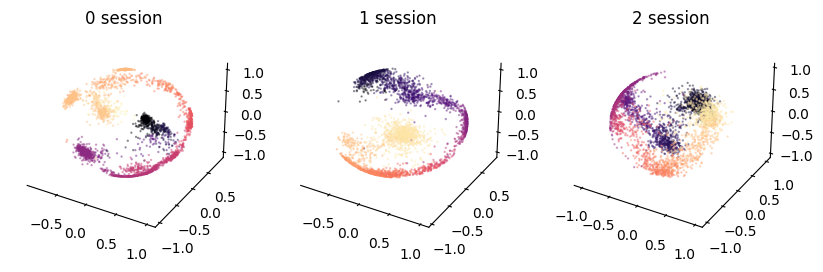

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(131, projection='3d')
ax2 = plt.subplot(132, projection='3d')
ax3 = plt.subplot(133, projection='3d')
axes = [ax1, ax2, ax3]

for i, ax in enumerate(axes):
    cebra_plot.plot_embedding(embeddings[i],
                              cmap='magma',
                              ax = ax,
                              alpha=0.4,
                              markersize=0.5,
                              title = f'{i} session',
                              embedding_labels=sessions[i]['tail_position'])

Looks cool, right? 🎉 Lets boost our model by combining the data for training CEBRA in multisession regime:)

## CEBRA-Multisession

In [24]:
#this is just the list of neural data = [neural_data_1, ...]
datas = [session['neural'] for session in sessions]

#this is just the list of labels = [labels_1, ...]
labels = [session['tail_position'] for session in sessions]

In [28]:
multi_embeddings = dict()

# Multisession training
multi_cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=1024,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=500,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

multi_cebra_model.fit(datas, labels)



pos:  0.3573 neg:  7.2235 total:  7.5807 temperature:  1.0000: 100%|██████████| 500/500 [21:25<00:00,  2.57s/it]


CEBRA(batch_size=1024, conditional='time_delta', max_iterations=500,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

In [29]:
for i, data in enumerate(datas):
    multi_embeddings[i] = multi_cebra_model.transform(data, session_id=i)

<IPython.core.display.Javascript object>

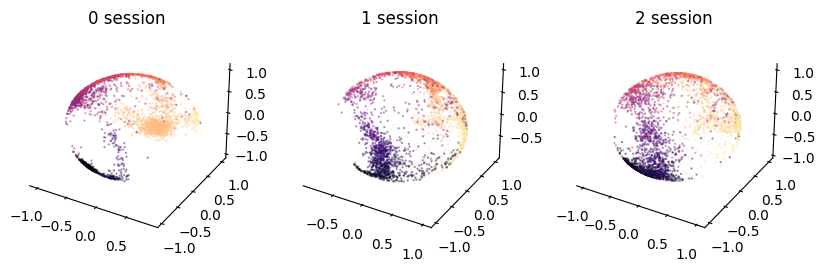

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(131, projection='3d')
ax2 = plt.subplot(132, projection='3d')
ax3 = plt.subplot(133, projection='3d')
axes = [ax1, ax2, ax3]

for i, ax in enumerate(axes):
    cebra_plot.plot_embedding(multi_embeddings[i],
                              cmap='magma',
                              ax = ax,
                              alpha=0.4,
                              markersize=0.5,
                              title = f'{i} session',
                              embedding_labels=sessions[i]['tail_position'])

### We also want to check consistency across sessions!

 - this is also useful to compare across animals (see Schneider, Lee, Mathis Nature 2023, Figure 1)
 - or compare across brain areas, tasks, etc .. anything you want to compare 🧠
 - in our case the comparison is across datasets (trials)

In [34]:
multi_embeddings_union = list(multi_embeddings.values())
tail_position_union = [session['tail_position']
                       for session in sessions]

In [ ]:
scores, pairs, runs = cebra.sklearn.metrics.consistency_score(embeddings=multi_embeddings_union,
                                                              between='datasets',
                                                              labels=tail_position_union)



In [ ]:
%matplotlib inline
ax = cebra_plot.plot_consistency(scores,
                                 pairs=pairs,
                                 datasets=runs,
                                 title="CEBRA-Behaviour-consistency-1P", cmap='cebra')

Great job! You are now master of CEBRA and DeepLabCut:)